In [24]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 100
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
dataPath = ('H:/Document/Program/hands on machine learning with scikit learn and tensorflow/handson_ml/handson-ml-master/datasets/mnist/')
dataFile = 'mnist_train.csv'

In [4]:
train = pd.read_csv(dataPath + dataFile)

In [7]:
from sklearn.datasets import fetch_mldata

In [9]:
#mnist = fetch_mldata('MNIST original')

In [4]:
data = scipy.io.loadmat(dataPath + 'mnist-original.mat')

In [5]:
train = data.copy()
train_feature = train['data']
train_response = train['label']

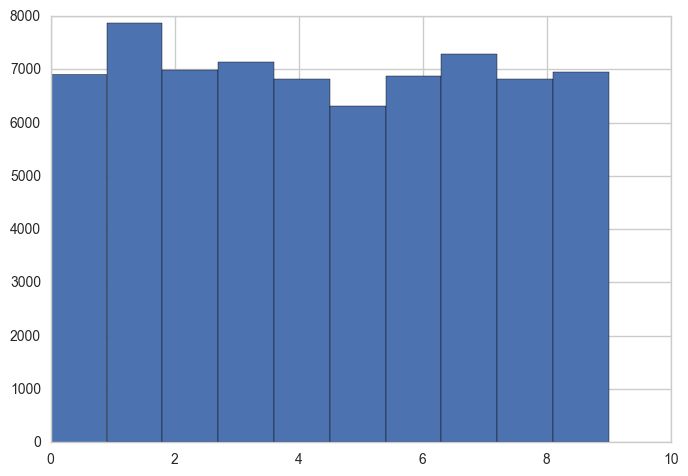

In [6]:
plt.hist(train_response.T);

In [26]:
from sklearn.cross_validation import train_test_split

In [31]:
xtrain_1stLayer, xvalid_1stLayer, ytrain_1stLayer, yvalid_1stLayer = train_test_split(train_feature.T, train_response.T)

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [35]:
?GridSearchCV

In [33]:
#gbmGrid = GridSearchCV(GradientBoostingClassifier(), par)

# Stacking using Titanic dataset

In [25]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [26]:
titanic_Path = ('H:/Document/Program/Kaggle/Titanic//')
titanic_train = 'train.csv'
titanic_test = 'test.csv'

In [75]:
train_titanic = pd.read_csv(titanic_Path + titanic_train)
test_titanic = pd.read_csv(titanic_Path + titanic_test)

In [49]:
categoric_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

In [76]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Embarked', 'Sex']
train_titanic = train_titanic.drop(drop_elements, axis = 1)
#train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test_titanic  = test_titanic.drop(drop_elements, axis = 1)

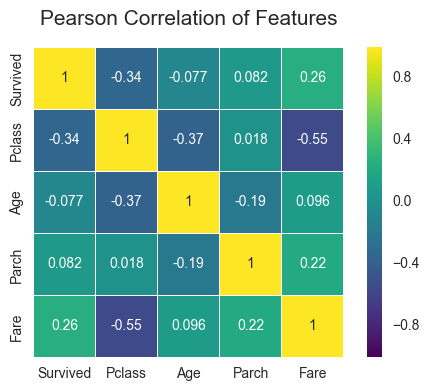

In [51]:
colormap = plt.cm.viridis
plt.figure(figsize=(6,4))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_titanic.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

In [ ]:
#g = sns.pairplot(train_titanic[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked']], 
#                 hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
#g.set(xticklabels=[])

In [56]:
from sklearn.cross_validation import KFold

In [57]:
# Some useful parameters which will come in handy later on
ntrain = train_titanic.shape[0]
ntest = test_titanic.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

In [113]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        return(self.clf.fit(x,y).feature_importances_)

### Out-of-Fold Predictions

Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [70]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.zeros((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models 

So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

 1. Random Forest classifier
 2. Extra Trees classifier
 3. AdaBoost classifer
 4. Gradient Boosting classifer
 5. Support Vector Machine

In [117]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     #'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [119]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

**Creating NumPy arrays out of our train and test sets**

Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes as follows:

In [ ]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train_titanic['Survived'].ravel()
train_titanic = train_titanic.drop(['Survived'], axis=1)
x_train = train_titanic.values # Creates an array of the train data
x_test = test_titanic.values # Creats an array of the test data

**Output of the First level Predictions** 

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.

In [121]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [159]:
oof_train = np.zeros((ntrain,))
print(oof_train.shape)
oof_test = np.zeros((ntest,))
print(oof_test.shape)
oof_test_skf = np.zeros((NFOLDS, ntest))
print(oof_test_skf.shape)
print(x_train.shape)

for i, (train_idx, test_idx) in enumerate(kf):
    if i == 0:
        x_tr = x_train[train_idx]
        y_tr = y_train[train_idx]
        x_te = x_train[test_idx]
        print(x_tr.shape, x_te.shape, y_tr.shape)
        rf.fit(x_tr, y_tr)
        rf_pred = rf.predict(x_te)
        oof_train[test_idx] = rf_pred
        oof_test_skf[i, :] = rf.predict(x_test)
        print(oof_test_skf.shape)

(891,)
(418,)
(5, 418)
(891, 5)
(712, 5) (179, 5) (712,)
(5, 418)


In [ ]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.zeros((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [95]:
test_titanic.columns

Index(['Pclass', 'Age', 'Parch', 'Fare'], dtype='object')

In [122]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[ 0.22611231  0.25942487  0.06414102  0.45032181]
[ 0.45454687  0.17433386  0.11125208  0.25786719]
[ 0.03   0.232  0.022  0.716]
[ 0.03956975  0.42494289  0.04268733  0.49280003]


In [123]:
rf_feature

array([ 0.22611231,  0.25942487,  0.06414102,  0.45032181])

In [124]:
cols = train_titanic.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

In [125]:
feature_dataframe['Random Forest feature importances'].values

array([ 0.22611231,  0.25942487,  0.06414102,  0.45032181])

In [126]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [127]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boost feature importances',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [128]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.030,0.454547,0.039570,0.226112,Pclass,0.187557
1,0.232,0.174334,0.424943,0.259425,Age,0.272675
2,0.022,0.111252,0.042687,0.064141,Parch,0.060020


In [129]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the First-level Output

**First-level output as new features**

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [131]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [132]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [133]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [162]:
y_train.shape

(891,)

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

### Second level learning model via XGBoost

Here we choose the eXtremely famous library for boosted tree learning model.

In [136]:
import xgboost as xgb

In [138]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

In [139]:
gbm.fit(x_train, y_train)
predictions = gbm.predict(x_test)

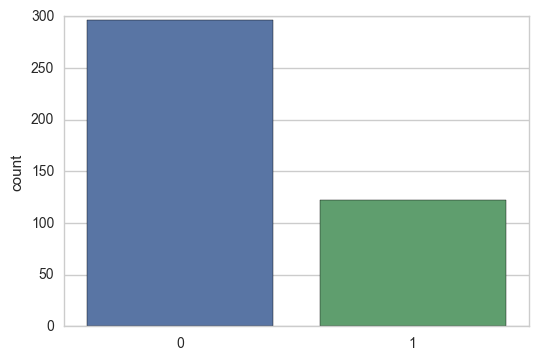

In [143]:
sns.countplot(predictions);

# tSNE

In [47]:
X, y = train['data'].T / 255.0, train['label'].T

In [48]:
from sklearn.decomposition import PCA
# Create subset and reduce to first 50 dimensions
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
n_train_samples = 5000
X_pca = PCA(n_components=50).fit_transform(X)
X_train = X_pca[indices[:n_train_samples]]
y_train = y[indices[:n_train_samples]]

In [90]:
from matplotlib import *
# Plotting function
matplotlib.rc('font', **{'family' : 'sans-serif',
                         'weight' : 'bold',
                         'size'   : 18})
matplotlib.rc('text', **{'usetex' : True})

def plot_mnist(X, y, X_embedded, name, min_dist=10.0):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(frameon=False)
    plt.title("\\textbf{MNIST dataset} -- Two-dimensional "
          "embedding of 70,000 handwritten digits with %s" % name)
    #setp(ax, xticks=(), yticks=())
    #subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
    #                wspace=0.0, hspace=0.0)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x")
    
    if min_dist is not None:
        from matplotlib import offsetbox
        shown_images = np.array([[15., 15.]])
        indices = np.arange(X_embedded.shape[0])
        np.random.shuffle(indices)
        for i in indices[:5000]:
            dist = np.sum((X_embedded[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist:
                continue
            shown_images = np.r_[shown_images, [X_embedded[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X[i].reshape(28, 28),
                                      cmap=cm.gray_r), X_embedded[i])
            ax.add_artist(imagebox)

In [52]:
from sklearn.manifold import TSNE
X_train_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_train)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.040377
[t-SNE] Iteration 25: error = 1.7691797, gradient norm = 0.0109741
[t-SNE] Iteration 50: error = 1.7005069, gradient norm = 0.0063813
[t-SNE] Iteration 75: error = 1.4608802, gradient norm = 0.0021239
[t-SNE] Iteration 100: error = 1.4139912, gradient norm = 0.0017693
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.413991
[t-SNE] Iteration 125: error = 1.3369025, gradient norm = 0.0013219
[t-SNE] Iteration 150: error = 1.3126496, gradient norm = 0.0012065
[t-SNE] Iteration 175: error = 1.3065810, gradient norm = 0.0011805
[t-SNE] 

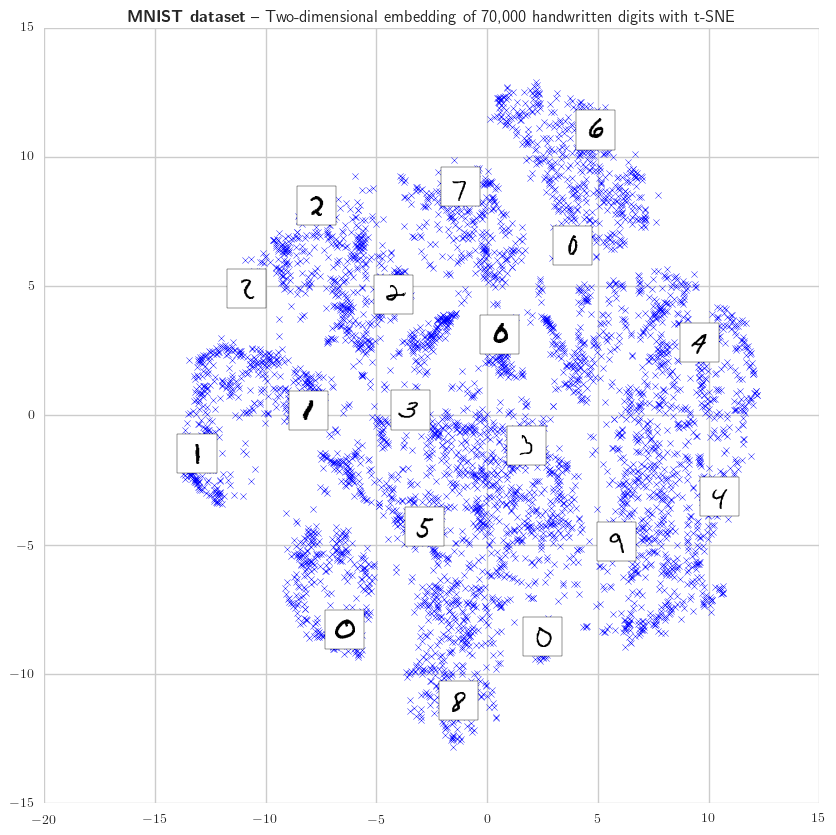

In [91]:
plot_mnist(X[indices[:n_train_samples]], y_train, X_train_embedded,
           "t-SNE", min_dist=20.0)